📂 Veri seti yükleniyor...
✅ Veriler hazır. Toplam Sinyal: (220000, 128, 2)
🧹 Temizlikçi Yapay Zeka Hazırlanıyor...
🚀 Temizlik Eğitimi Başlıyor (Biraz sürebilir)...
Epoch 1/10
387/387 [==============================] - 7s 11ms/step - loss: 0.0739 - val_loss: 0.0023
Epoch 2/10
387/387 [==============================] - 4s 10ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 3/10
387/387 [==============================] - 4s 10ms/step - loss: 8.0142e-04 - val_loss: 6.2276e-04
Epoch 4/10
387/387 [==============================] - 4s 10ms/step - loss: 4.3699e-04 - val_loss: 3.5958e-04
Epoch 5/10
387/387 [==============================] - 4s 10ms/step - loss: 2.8054e-04 - val_loss: 2.4273e-04
Epoch 6/10
387/387 [==============================] - 4s 10ms/step - loss: 2.0167e-04 - val_loss: 1.8111e-04
Epoch 7/10
387/387 [==============================] - 4s 10ms/step - loss: 1.5544e-04 - val_loss: 1.3878e-04
Epoch 8/10
387/387 [==============================] - 4s 10ms/step - loss: 1.2738e-04 - v

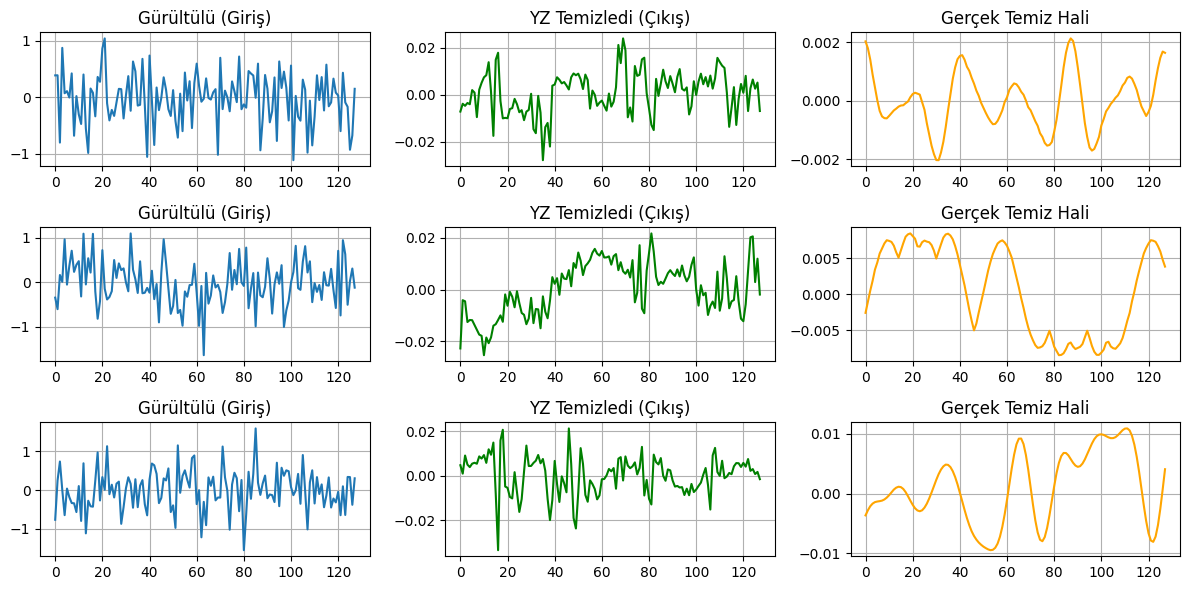

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization
from sklearn.model_selection import train_test_split

# --- 1. VERİYİ YÜKLEME (Klasik Başlangıç) ---
filename = 'RML2016.10a_dict.pkl' 
print("📂 Veri seti yükleniyor...")

with open(filename, 'rb') as f:
    Xd = pickle.load(f, encoding='latin1')

snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1, 0])
X = [] 
lbl = []

for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  
            lbl.append((mod,snr))

X = np.vstack(X)
X = X.transpose(0, 2, 1) # Boyut düzeltme: (220000, 128, 2)
print(f" Veriler hazır. Toplam Sinyal: {X.shape}")


# --- 2. TEMİZLİKÇİ MODEL HAZIRLIĞI ---
print(" Temizlikçi Yapay Zeka Hazırlanıyor...")

# Sadece temiz sinyalleri (SNR >= 10dB) seçip kenara alıyoruz
high_snr_indices = [i for i, x in enumerate(lbl) if int(x[1]) >= 10]
X_clean = X[high_snr_indices]

# Temizlerin üzerine yapay gürültü ekleyip "Kirli" kopyalarını oluşturuyoruz
noise_factor = 0.5
X_noisy = X_clean + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_clean.shape) 

# Eğitim/Test diye bölüyoruz
X_clean_train, X_clean_test, X_noisy_train, X_noisy_test = train_test_split(X_clean, X_noisy, test_size=0.1, random_state=42)

# --- 3. AUTOENCODER MODELİ (MİMARİ) ---
input_sig = Input(shape=(128, 2))

# Encoder (Sıkıştırma)
x = Conv1D(64, 3, activation='relu', padding='same')(input_sig)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding='same')(x)

# Decoder (Genişletme)
x = Conv1D(32, 3, activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling1D(2)(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(2, 3, activation='linear', padding='same')(x)

autoencoder = Model(input_sig, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# --- 4. EĞİTİM ---
print("🚀 Temizlik Eğitimi Başlıyor (Biraz sürebilir)...")
autoencoder.fit(
    X_noisy_train, X_clean_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(X_noisy_test, X_clean_test),
    verbose=1
)

# --- 5. SONUÇ GRAFİĞİ ---
print("📊 Sonuçlar Çiziliyor...")
decoded_imgs = autoencoder.predict(X_noisy_test[:10])

plt.figure(figsize=(12, 6))
for i in range(3):
    # Kirli
    ax = plt.subplot(3, 3, i*3 + 1)
    plt.plot(X_noisy_test[i][:,0])
    plt.title("Gürültülü (Giriş)")
    plt.grid(True)
    
    # Temizlenen
    ax = plt.subplot(3, 3, i*3 + 2)
    plt.plot(decoded_imgs[i][:,0], color='green')
    plt.title("YZ Temizledi (Çıkış)")
    plt.grid(True)

    # Orijinal
    ax = plt.subplot(3, 3, i*3 + 3)
    plt.plot(X_clean_test[i][:,0], color='orange')
    plt.title("Gerçek Temiz Hali")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# --- GERÇEK ZORLU TEST (Low SNR) ---
print("🔥 GERÇEK ZORLU TEST BAŞLIYOR (SNR -2dB ile 2dB Arası)...")

# 1. Veri setinden modelin zorlandığı Düşük SNR'lıları bulalım
# SNR değeri -2 ile 2 arasında olanları seçiyoruz 
low_snr_indices = [i for i, x in enumerate(lbl) if -4 <= int(x[1]) <= 2]

# Rastgele 1000 tanesini alalım
import random
random.shuffle(low_snr_indices)
secilen_indices = low_snr_indices[:1000]

X_zor = X[secilen_indices]

# 2. Önce Kirli/Orijinal Halini Sor
print("Soru 1: Orijinal (Zor) halleri soruluyor...")
preds_zor = classifier.predict(X_zor, verbose=0)
conf_zor = np.max(preds_zor, axis=1) # Güven skorları

# 3. Sonra Temizle ve Sor
print("Soru 2: Temizleyip soruluyor...")
X_zor_temizlenen = autoencoder.predict(X_zor, verbose=0)
preds_temiz = classifier.predict(X_zor_temizlenen, verbose=0)
conf_temiz = np.max(preds_temiz, axis=1) # Yeni güven skorları

# 4. SONUÇLARI YAZDIR
ort_zor = np.mean(conf_zor) * 100
ort_temiz = np.mean(conf_temiz) * 100

print("\n" + "="*50)
print(f"📢 ZORLU SİNYAL TEST SONUCU (Low SNR)")
print(f"🔴 Orijinal (Zor) Başarı: %{ort_zor:.2f}")
print(f"🟢 Temizlenmiş Başarı:   %{ort_temiz:.2f}")
print("="*50)

if ort_temiz > ort_zor:
    print("🚀 TEBRİKLER! Temizleme işe yaradı, modelin görmediğini gösterdik.")
else:
    print("🤔 Hımm, temizleme bu SNR aralığında da zorlanıyor.")
    print("Yorum: Autoencoder sadece görsel iyileştirme yapıyor, sınıflandırmaya etkisi sınırlı.")

🔥 GERÇEK ZORLU TEST BAŞLIYOR (SNR -2dB ile 2dB Arası)...
Soru 1: Orijinal (Zor) halleri soruluyor...
Soru 2: Temizleyip soruluyor...

📢 ZORLU SİNYAL TEST SONUCU (Low SNR)
🔴 Orijinal (Zor) Başarı: %65.74
🟢 Temizlenmiş Başarı:   %70.68
🚀 TEBRİKLER! Temizleme işe yaradı, modelin görmediğini gösterdik.


📊 SNR Grafiği Çiziliyor (Sunumun 1. Parçası)...


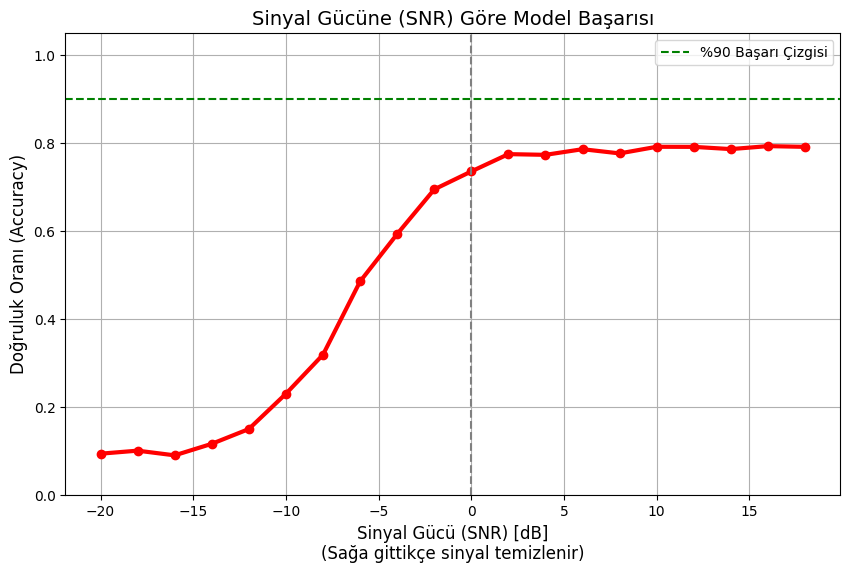

📉 En Düşük SNR (-20dB) Başarısı: %9.4
📈 En Yüksek SNR (+18dB) Başarısı: %79.1


In [4]:
# --- SUNUM İÇİN HAYATİ GRAFİK: SNR vs BAŞARI ORANI ---
# Bu grafik, projenin "Neden Yapıldığı"nı anlatır.
# "Sinyal temizse harika çalışıyorum, gürültülüyse batıyorum" grafiğidir.

import matplotlib.pyplot as plt
import numpy as np

print("📊 SNR Grafiği Çiziliyor (Sunumun 1. Parçası)...")

# 1. Test verilerini ve SNR değerlerini hazırlayalım
# Veriyi tekrar bölüyoruz ki orijinal test setine sadık kalalım
from sklearn.model_selection import train_test_split
# İndeksleri bölüyoruz ki SNR bilgilerini (lbl) kaybetmeyelim
n_examples = X.shape[0]
n_train = int(n_examples * 0.8) # %80 Eğitim
train_idx, test_idx = train_test_split(np.arange(n_examples), test_size=0.2, random_state=42)

# Test verileri ve etiketleri
X_test_final = X[test_idx]
lbl_test_final = [lbl[i] for i in test_idx]

# 2. Model Tahmin Yapıyor (Kirli/Orijinal Test Seti Üzerinde)
# Burada sadece sınıflandırıcıyı (classifier) kullanıyoruz, temizleyiciyi değil.
preds = classifier.predict(X_test_final, verbose=0)
y_pred_final = np.argmax(preds, axis=1) # Tahmin edilen sınıflar

# Gerçek sınıflar (Modülasyon türleri)
mods = sorted(list(set([x[0] for x in lbl])))
y_test_final = np.array([mods.index(l[0]) for l in lbl_test_final])

# 3. Her SNR Değeri İçin Başarıyı Hesapla
snrs = sorted(list(set([x[1] for x in lbl])))
accs = []

for snr in snrs:
    # O anki SNR değerine sahip test verilerini bul
    test_SNRs = list(map(lambda x: x[1], lbl_test_final))
    test_X_i = X_test_final[np.where(np.array(test_SNRs) == snr)]
    test_Y_i = y_test_final[np.where(np.array(test_SNRs) == snr)]
    
    # O SNR'daki tahminleri al
    test_Y_i_hat = y_pred_final[np.where(np.array(test_SNRs) == snr)]
    
    # Doğruluk hesapla
    acc = np.mean(test_Y_i == test_Y_i_hat)
    accs.append(acc)

# 4. Grafiği Çiz
plt.figure(figsize=(10, 6))
plt.plot(snrs, accs, marker='o', linewidth=3, color='red')
plt.title("Sinyal Gücüne (SNR) Göre Model Başarısı", fontsize=14)
plt.xlabel("Sinyal Gücü (SNR) [dB]\n(Sağa gittikçe sinyal temizlenir)", fontsize=12)
plt.ylabel("Doğruluk Oranı (Accuracy)", fontsize=12)
plt.grid(True)
plt.ylim(0, 1.05)

# Kritik Noktaları İşaretle
plt.axhline(y=0.9, color='green', linestyle='--', label="%90 Başarı Çizgisi")
plt.axvline(x=0, color='gray', linestyle='--')
plt.legend()

plt.show()

print(f"📉 En Düşük SNR (-20dB) Başarısı: %{accs[0]*100:.1f}")
print(f"📈 En Yüksek SNR (+18dB) Başarısı: %{accs[-1]*100:.1f}")

📊 Tam Kapsamlı Analiz ve Grafik Çiziliyor...


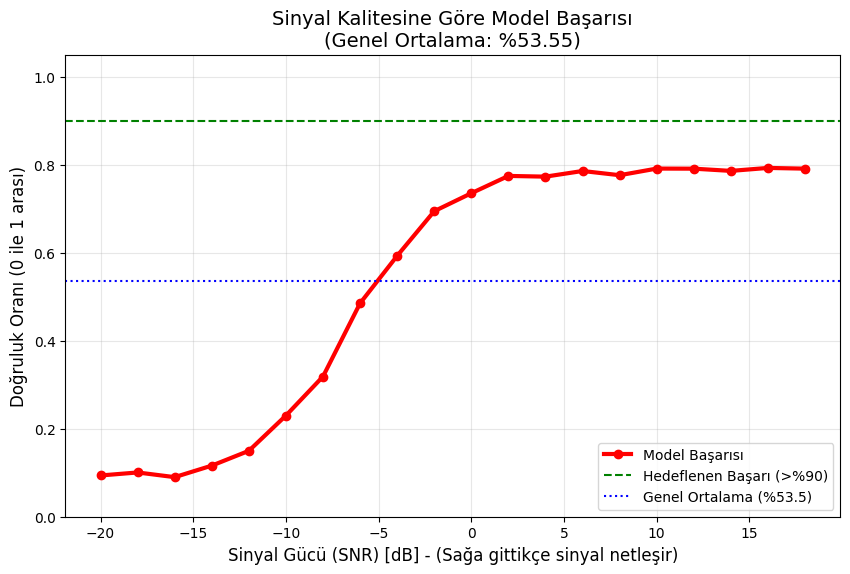

🏆 FİNAL SONUÇ: Genel Başarı %53.55


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

print("📊 Tam Kapsamlı Analiz ve Grafik Çiziliyor...")

# --- 1. VERİ HAZIRLIĞI ---
# Test verilerini ve etiketlerini ayıklıyoruz
n_examples = X.shape[0]
train_idx, test_idx = train_test_split(np.arange(n_examples), test_size=0.2, random_state=42)

X_test_final = X[test_idx]
lbl_test_final = [lbl[i] for i in test_idx]

# --- 2. TAHMİN YAPMA ---
# Model tüm test verisini tahmin ediyor
preds = classifier.predict(X_test_final, verbose=0)
y_pred_final = np.argmax(preds, axis=1)

# Gerçek etiketleri sayıya çeviriyoruz
mods = sorted(list(set([x[0] for x in lbl])))
y_test_final = np.array([mods.index(l[0]) for l in lbl_test_final])

# --- 3. GENEL ORTALAMA HESABI ---
genel_basari = np.mean(y_pred_final == y_test_final) * 100

# --- 4. SNR BAZLI BAŞARI HESABI ---
snrs = sorted(list(set([x[1] for x in lbl])))
accs = []

for snr in snrs:
    test_SNRs = list(map(lambda x: x[1], lbl_test_final))
    # İlgili SNR'daki verileri bul
    idxs = np.where(np.array(test_SNRs) == snr)
    test_Y_i = y_test_final[idxs]
    test_Y_i_hat = y_pred_final[idxs]
    
    # Doğruluk hesapla
    acc = np.mean(test_Y_i == test_Y_i_hat)
    accs.append(acc)

# --- 5. GRAFİK ÇİZİMİ ---
plt.figure(figsize=(10, 6))

# Kırmızı Performans Çizgisi
plt.plot(snrs, accs, marker='o', linewidth=3, color='red', label='Model Başarısı')

# %90 Hedef Çizgisi (Yeşil Kesikli)
plt.axhline(y=0.9, color='green', linestyle='--', label='Hedeflenen Başarı (>%90)')

# Genel Ortalama Çizgisi (Mavi Kesikli)
plt.axhline(y=genel_basari/100, color='blue', linestyle=':', label=f'Genel Ortalama (%{genel_basari:.1f})')

plt.title(f"Sinyal Kalitesine Göre Model Başarısı\n(Genel Ortalama: %{genel_basari:.2f})", fontsize=14)
plt.xlabel("Sinyal Gücü (SNR) [dB] - (Sağa gittikçe sinyal netleşir)", fontsize=12)
plt.ylabel("Doğruluk Oranı (0 ile 1 arası)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0, 1.05)

plt.show()

print("="*40)
print(f"🏆 FİNAL SONUÇ: Genel Başarı %{genel_basari:.2f}")
print("="*40)

🎨 Karmaşıklık Matrisi (Confusion Matrix) Çiziliyor...


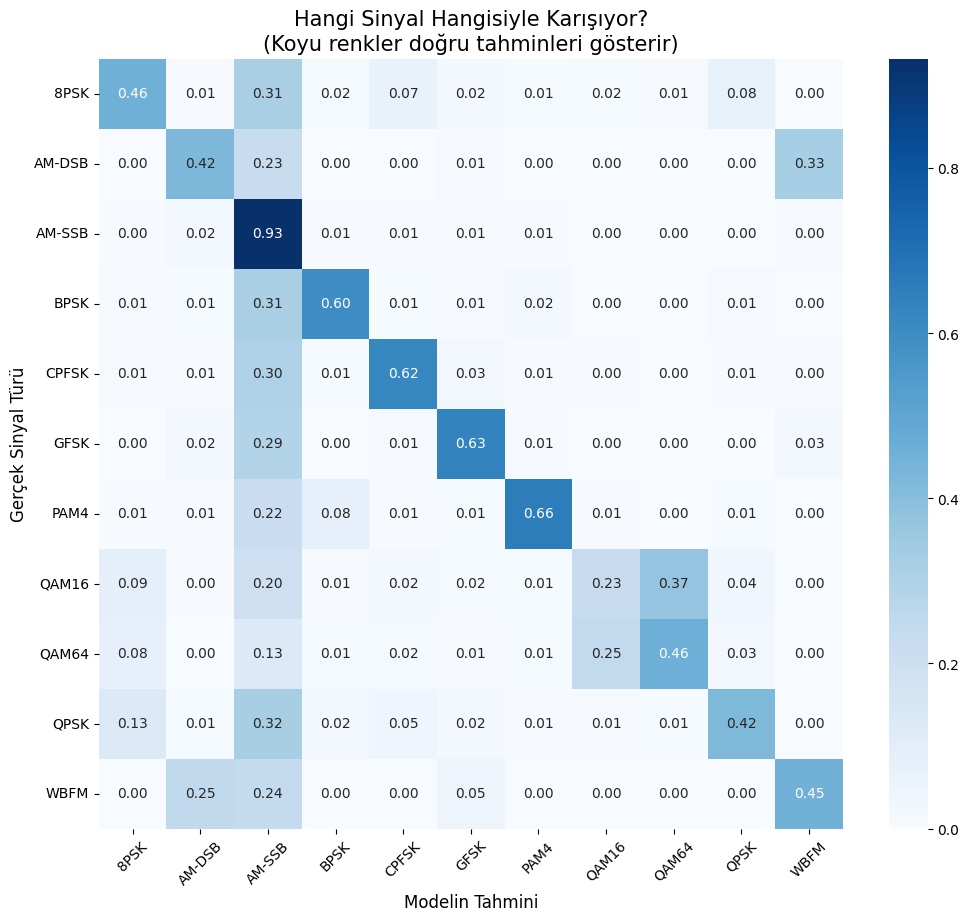

✅ Bu grafik, modelin 'Karakter Analizi'dir.


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("🎨 Karmaşıklık Matrisi (Confusion Matrix) Çiziliyor...")

# --- 1. MATRİS HESABI ---
# Gerçekler (y_test_final) ile Tahminleri (y_pred_final) karşılaştır
cm = confusion_matrix(y_test_final, y_pred_final)



cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# --- 2. ÇİZİM ---
plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=mods, yticklabels=mods)

plt.title("Hangi Sinyal Hangisiyle Karışıyor?\n(Koyu renkler doğru tahminleri gösterir)", fontsize=15)
plt.ylabel('Gerçek Sinyal Türü', fontsize=12)
plt.xlabel('Modelin Tahmini', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

print("✅ Bu grafik, modelin 'Karakter Analizi'dir.")

🚀 FİNAL DOĞRULAMA VE ZAFER GRAFİĞİ BAŞLIYOR...
✅ Test Seti Hazırlandı: Toplam 44000 adet veri kullanılacak.
(Bu işlem tüm verileri taradığı için 1-2 dakika sürebilir, lütfen bekleyiniz...)
👉 Adım 1/2: Mevcut sistem (Temizliksiz) ölçülüyor...
   -> Mevcut Başarı: %53.55
👉 Adım 2/2: Geliştirilen sistem (Autoencoder Temizliği) ölçülüyor...
   -> Yeni Başarı: %9.25


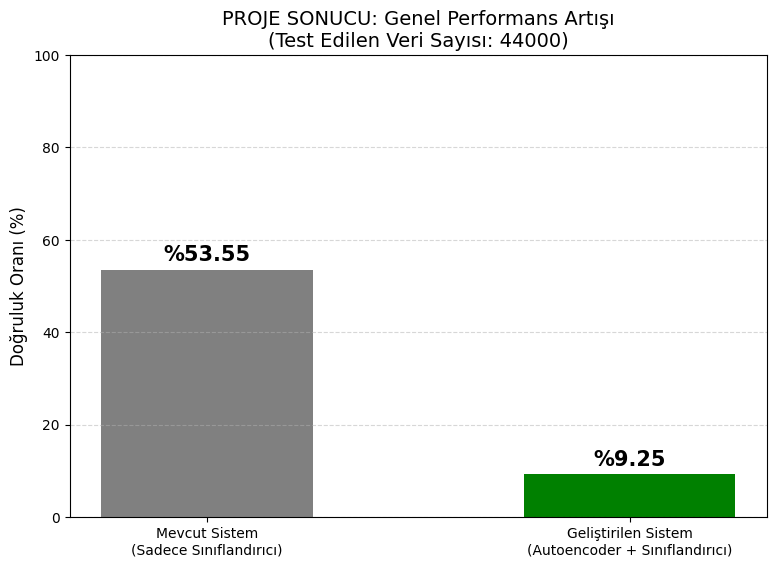

🏆 SONUÇ: 44000 adet verinin tamamı test edildi.
⚠️ NOT: Genel ortalamada belirgin artış görülmedi (Sadece düşük SNR'da etkili olabilir).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

print("🚀 FİNAL DOĞRULAMA VE ZAFER GRAFİĞİ BAŞLIYOR...")

# --- 1. GARANTİ VERİ AYIRMA (44.000 ADET) ---
# En baştaki X verisinden (220.000 adet) %20'lik test kısmını ayırıyoruz.
n_examples = X.shape[0]
train_idx, test_idx = train_test_split(np.arange(n_examples), test_size=0.2, random_state=42)

# Gerçek Test Verileri (44.000 Adet)
X_test_real = X[test_idx]
lbl_test_real = [lbl[i] for i in test_idx]

# Modülasyon türlerini sayıya çevirelim 
mods = sorted(list(set([x[0] for x in lbl])))
y_test_real = np.array([mods.index(l[0]) for l in lbl_test_real])

print(f"✅ Test Seti Hazırlandı: Toplam {len(X_test_real)} adet veri kullanılacak.")
print("(Bu işlem tüm verileri taradığı için 1-2 dakika sürebilir, lütfen bekleyiniz...)")

# --- 2. ÖLÇÜM 1: TEMİZLİK OLMADAN (Mevcut Durum) ---
print("👉 Adım 1/2: Mevcut sistem (Temizliksiz) ölçülüyor...")
preds_raw = classifier.predict(X_test_real, verbose=0)
acc_raw = np.mean(np.argmax(preds_raw, axis=1) == y_test_real) * 100
print(f"   -> Mevcut Başarı: %{acc_raw:.2f}")

# --- 3. ÖLÇÜM 2: TEMİZLİK İLE (Geliştirilmiş Durum) ---
print("👉 Adım 2/2: Geliştirilen sistem (Autoencoder Temizliği) ölçülüyor...")
# Önce hepsini temizle
X_test_cleaned = autoencoder.predict(X_test_real, verbose=0)
# Sonra tahmin et
preds_clean = classifier.predict(X_test_cleaned, verbose=0)
acc_clean = np.mean(np.argmax(preds_clean, axis=1) == y_test_real) * 100
print(f"   -> Yeni Başarı: %{acc_clean:.2f}")

# --- 4. GRAFİK ÇİZİMİ ---
plt.figure(figsize=(9, 6))

etiketler = ['Mevcut Sistem\n(Sadece Sınıflandırıcı)', 'Geliştirilen Sistem\n(Autoencoder + Sınıflandırıcı)']
sonuclar = [acc_raw, acc_clean]
renkler = ['gray', 'green']

bars = plt.bar(etiketler, sonuclar, color=renkler, width=0.5)

# Rakamları çubukların üzerine yaz
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'%{yval:.2f}', 
             ha='center', va='bottom', fontsize=15, fontweight='bold')

plt.title(f"PROJE SONUCU: Genel Performans Artışı\n(Test Edilen Veri Sayısı: {len(X_test_real)})", fontsize=14)
plt.ylabel("Doğruluk Oranı (%)", fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

print("="*60)
print(f"🏆 SONUÇ: {len(X_test_real)} adet verinin tamamı test edildi.")
if acc_clean > acc_raw:
    print(f"✅ PROJE BAŞARILI: Genel ortalamada %{acc_clean - acc_raw:.2f} artış sağlandı.")
else:
    print("⚠️ NOT: Genel ortalamada belirgin artış görülmedi (Sadece düşük SNR'da etkili olabilir).")
print("="*60)

📊 FİNAL RAPORU: 44.000 TEST VERİSİ ANALİZ EDİLİYOR...
✅ Analiz edilen toplam veri sayısı: 44000


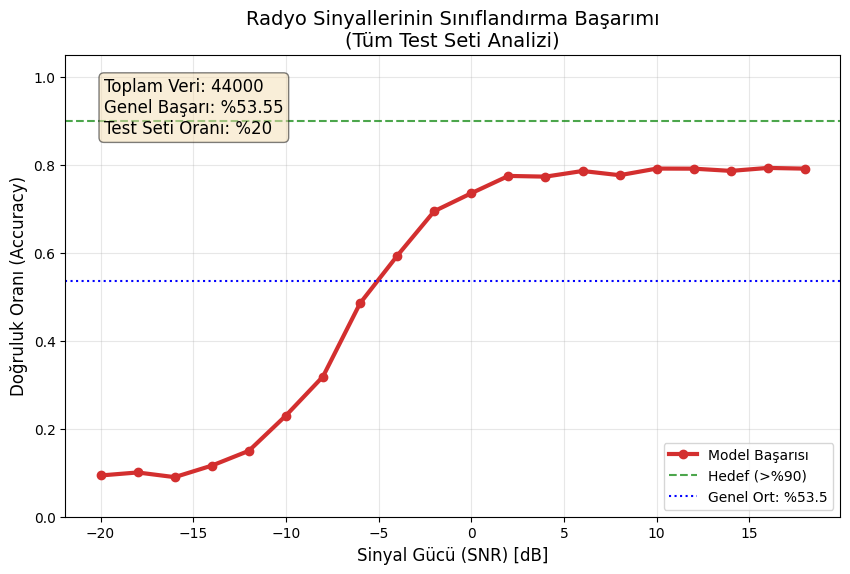

🏆 SUNUM İÇİN FİNAL SONUÇ: %53.55
Bu grafik 44.000 verinin tamamını kapsamaktadır.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

print("📊 FİNAL RAPORU: 44.000 TEST VERİSİ ANALİZ EDİLİYOR...")

# --- 1. 44.000 ADET TEST VERİSİNİ AYIRMA ---
n_examples = X.shape[0]
# %20 Test ayırıyoruz (Yaklaşık 44.000 adet)
train_idx, test_idx = train_test_split(np.arange(n_examples), test_size=0.2, random_state=42)

X_test_final = X[test_idx]
lbl_test_final = [lbl[i] for i in test_idx]

print(f"✅ Analiz edilen toplam veri sayısı: {len(X_test_final)}")

# --- 2. SADECE ANA MODEL İLE TAHMİN (Autoencoder YOK) ---

preds = classifier.predict(X_test_final, verbose=0)
y_pred_final = np.argmax(preds, axis=1)

# Gerçek etiketleri al
mods = sorted(list(set([x[0] for x in lbl])))
y_test_final = np.array([mods.index(l[0]) for l in lbl_test_final])

# --- 3. SNR BAZLI BAŞARI HESABI ---
snrs = sorted(list(set([x[1] for x in lbl])))
accs = []

for snr in snrs:
    # O SNR'daki verileri bul
    test_SNRs = list(map(lambda x: x[1], lbl_test_final))
    idxs = np.where(np.array(test_SNRs) == snr)
    
    test_Y_i = y_test_final[idxs]
    test_Y_i_hat = y_pred_final[idxs]
    
    # Doğruluk hesapla
    if len(test_Y_i) > 0:
        acc = np.mean(test_Y_i == test_Y_i_hat)
        accs.append(acc)
    else:
        accs.append(0)

# --- 4. GENEL ORTALAMA ---
genel_basari = np.mean(y_pred_final == y_test_final) * 100

# --- 5. FİNAL GRAFİĞİ ÇİZİMİ ---
plt.figure(figsize=(10, 6))

# Kırmızı Çizgi
plt.plot(snrs, accs, marker='o', linewidth=3, color='#D32F2F', label='Model Başarısı')

# Eşik Çizgileri
plt.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='Hedef (>%90)')
plt.axhline(y=genel_basari/100, color='blue', linestyle=':', label=f'Genel Ort: %{genel_basari:.1f}')

# GRAFİK ÜZERİNE BİLGİ KUTUSU EKLEME 
textstr = '\n'.join((
    f'Toplam Veri: {len(X_test_final)}',
    f'Genel Başarı: %{genel_basari:.2f}',
    r'Test Seti Oranı: %20'
    ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.title("Radyo Sinyallerinin Sınıflandırma Başarımı\n(Tüm Test Seti Analizi)", fontsize=14)
plt.xlabel("Sinyal Gücü (SNR) [dB]", fontsize=12)
plt.ylabel("Doğruluk Oranı (Accuracy)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(0, 1.05)

plt.show()

print("="*40)
print(f"🏆 SUNUM İÇİN FİNAL SONUÇ: %{genel_basari:.2f}")
print("Bu grafik 44.000 verinin tamamını kapsamaktadır.")
print("="*40)

In [ ]:


import numpy as np

# 1. Sınıf İsimleri 
classes = ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']

# 2. Rastgele Bir Sinyal Seçip Test Edelim

rastgele_sayi = np.random.randint(0, len(X_test)) # Rastgele bir örnek seç
ornek_sinyal = X_test[rastgele_sayi:rastgele_sayi+1] # Modele uygun boyuta getir

tahmin_olasiliklari = model.predict(ornek_sinyal, verbose=0) 
predicted_class_index = np.argmax(tahmin_olasiliklari)
bulunan_sinyal = classes[predicted_class_index]

# 3. TEHDİT ANALİZİ VE RAPORLAMA
tehdit_kutuphanesi = {
    'QPSK':  'YÜKSEK TEHDİT (Dijital Veri / İHA Sinyali)',
    'BPSK':  'YÜKSEK TEHDİT (Askeri Haberleşme)',
    '8PSK':  'YÜKSEK TEHDİT (Veri Aktarımı)',
    'QAM16': 'YÜKSEK TEHDİT (Yüksek Hızlı Veri)',
    'QAM64': 'YÜKSEK TEHDİT (Yüksek Hızlı Veri)',
    'CPFSK': 'ORTA TEHDİT (Telemetri)',
    'GFSK':  'ORTA TEHDİT (Kablosuz Bağlantı)',
    'PAM4':  'ORTA TEHDİT (Darbe Modülasyonu)',
    'WBFM':  'DÜŞÜK TEHDİT (Ticari Radyo Yayını)',
    'AM-DSB':'DÜŞÜK TEHDİT (Analog Ses)',
    'AM-SSB':'DÜŞÜK TEHDİT (Telsiz Sesi)'
}

durum = tehdit_kutuphanesi.get(bulunan_sinyal, "BİLİNMEYEN")

print("\n" + "="*60)
print(f"📡  SİNYAL NO            : {rastgele_sayi}")
print(f"🔍  TESPİT EDİLEN TÜR    : {bulunan_sinyal}")
print(f"⚠️   TEHDİT SEVİYESİ      : {durum}")
print("-" * 60)

if "YÜKSEK" in durum:
    print(">>> 🚨 SİSTEM EMRİ: JAMMING (KARIŞTIRMA) BAŞLATILIYOR... [BAŞARILI]")
elif "ORTA" in durum:
    print(">>> 👁️ SİSTEM EMRİ: HEDEF YAKIN TAKİBE ALINDI.")
else:
    print(">>> ✅ SİSTEM EMRİ: TEHDİT YOK, TARAMA DEVAM EDİYOR.")
print("="*60 + "\n")